In [1]:
import random
import time
import threading
import json
import logging
from dataclasses import dataclass, asdict
from typing import Dict, List, Optional, Tuple
from collections import deque
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


In [2]:
# IoT Device and Gateway Communication Simulation
@dataclass
class BatteryState:
    current_level: float  # percentage (0-100)
    voltage: float       # volts
    discharge_rate: float # mA/h
    estimated_remaining: float # hours
    temperature: float   # Celsius (affects battery performance)

@dataclass
class BandwidthState:
    uplink_capacity: float    # Mbps
    uplink_usage: float       # Mbps
    downlink_capacity: float  # Mbps
    downlink_usage: float     # Mbps
    packet_loss: float        # percentage
    latency: float           # milliseconds
    jitter: float            # milliseconds

@dataclass
class MemoryState:
    total_ram: int          # KB
    used_ram: int           # KB
    free_ram: int           # KB
    buffer_usage: int       # KB
    fragmentation: float    # percentage

@dataclass
class NetworkPacket:
    source_id: str
    destination: str
    size: int              # bytes
    timestamp: float
    packet_type: str
    priority: int          # 1-5 (5 = highest priority)
    retry_count: int       # number of retransmission attempts
    data: Optional[Dict] = None


In [ ]:
class IoTDevice:
    def __init__(self, device_id: str, device_type: str = "sensor", 
                 initial_battery: float = 100.0, location: Tuple[float, float] = (0.0, 0.0)):
        self.device_id = device_id
        self.device_type = device_type
        self.location = location  # (x, y) coordinates
        self.creation_time = time.time()
        
        # Enhanced device specifications
        device_specs = self._get_device_specifications(device_type)
        
        self.battery = BatteryState(
            current_level=initial_battery,
            voltage=device_specs['battery_voltage'],
            discharge_rate=device_specs['discharge_rate'],
            estimated_remaining=0.0,
            temperature=random.uniform(20.0, 35.0)  # Operating temperature
        )
        
        self.bandwidth = BandwidthState(
            uplink_capacity=device_specs['max_uplink'],
            uplink_usage=0.0,
            downlink_capacity=device_specs['max_downlink'],
            downlink_usage=0.0,
            packet_loss=0.0,
            latency=random.uniform(10, 50),  # Base latency in ms
            jitter=random.uniform(1, 5)     # Base jitter in ms
        )
        
        self.memory = MemoryState(
            total_ram=device_specs['total_ram'],
            used_ram=0,
            free_ram=0,
            buffer_usage=0,
            fragmentation=0.0
        )
        
        # Enhanced device state
        self.is_active = True
        self.packet_queue = deque(maxlen=device_specs['queue_limit'])
        self.last_transmission = time.time()
        self.network_condition = "GOOD"
        self.energy_harvesting = device_specs.get('energy_harvesting', False)
        self.sleep_mode = False
        
        # Statistics tracking
        self.stats = {
            'packets_sent': 0,
            'packets_failed': 0,
            'total_data_sent': 0,
            'avg_power_consumption': 0.0,
            'connection_uptime': 0.0
        }
        
        self._update_memory_state()
        logger.info(f"Device {device_id} ({device_type}) initialized at {location}")
    
    def _get_device_specifications(self, device_type: str) -> Dict:
        """Enhanced device specifications with more realistic parameters"""
        specs = {
            "sensor": {
                "total_ram": random.randint(8, 64),
                "battery_voltage": 3.3,
                "discharge_rate": random.uniform(0.5, 5.0),
                "max_uplink": 0.025,  # LoRaWAN typical
                "max_downlink": 0.025,
                "queue_limit": 10,
                "energy_harvesting": random.choice([True, False])  # Some sensors have solar panels
            },
            "actuator": {
                "total_ram": random.randint(16, 128),
                "battery_voltage": 3.7,
                "discharge_rate": random.uniform(5.0, 20.0),
                "max_uplink": 0.1,
                "max_downlink": 0.2,
                "queue_limit": 20,
                "energy_harvesting": False
            },
            "camera": {
                "total_ram": random.randint(512, 2048),
                "battery_voltage": 3.7,
                "discharge_rate": random.uniform(50.0, 200.0),
                "max_uplink": 2.0,
                "max_downlink": 0.5,
                "queue_limit": 50,
                "energy_harvesting": False
            },
            "gateway": {
                "total_ram": random.randint(1024, 8192),
                "battery_voltage": 5.0,
                "discharge_rate": random.uniform(100.0, 500.0),
                "max_uplink": 10.0,
                "max_downlink": 10.0,
                "queue_limit": 100,
                "energy_harvesting": False
            },
            "tracker": {
                "total_ram": random.randint(32, 256),
                "battery_voltage": 3.6,
                "discharge_rate": random.uniform(2.0, 15.0),
                "max_uplink": 0.05,
                "max_downlink": 0.05,
                "queue_limit": 15,
                "energy_harvesting": random.choice([True, False])
            }
        }
        return specs.get(device_type, specs["sensor"])
    
    def _update_battery_state(self, transmission_cost: float = 0.1):
        """Enhanced battery model with temperature effects and energy harvesting"""
        if self.battery.current_level <= 0:
            return
        
        # Temperature affects battery performance
        temp_factor = 1.0
        if self.battery.temperature > 35:
            temp_factor = 1.2  # Higher temperature = faster discharge
        elif self.battery.temperature < 10:
            temp_factor = 1.3  # Cold also affects battery
        
        # Base discharge calculation
        base_discharge = (self.battery.discharge_rate / 3600) * temp_factor
        
        # Sleep mode reduces power consumption significantly
        if self.sleep_mode:
            base_discharge *= 0.1
        
        # Transmission cost varies by device type and network condition
        transmission_multiplier = {
            "sensor": 0.1, "actuator": 0.5, "camera": 2.0, 
            "gateway": 1.0, "tracker": 0.3
        }.get(self.device_type, 0.5)
        
        if self.network_condition == "BAD":
            transmission_multiplier *= 2.0  # More retransmissions
        
        total_discharge = base_discharge + (transmission_cost * transmission_multiplier)
        
        # Energy harvesting can offset some consumption
        if self.energy_harvesting and random.random() < 0.3:  # 30% chance of harvesting
            harvest_amount = random.uniform(0.1, 0.5)
            total_discharge = max(0, total_discharge - harvest_amount)
        
        # Update battery level
        self.battery.current_level = max(0, self.battery.current_level - total_discharge)
        
        # Realistic Li-ion voltage curve
        if self.battery.current_level > 80:
            self.battery.voltage = self.battery.voltage * 0.99
        elif self.battery.current_level > 20:
            voltage_base = 2.8 if self.device_type == "sensor" else 3.0
            self.battery.voltage = voltage_base + (self.battery.current_level / 100) * 0.7
        else:
            self.battery.voltage = 2.5 + (self.battery.current_level / 100) * 0.5
        
        # Time remaining calculation
        if self.battery.discharge_rate > 0:
            hours_remaining = (self.battery.current_level / 100) * (1000 / self.battery.discharge_rate)
            self.battery.estimated_remaining = max(0, hours_remaining)
        
        # Update statistics
        self.stats['avg_power_consumption'] = (
            self.stats['avg_power_consumption'] * 0.9 + total_discharge * 0.1
        )
    
    def _update_memory_state(self):
        """Enhanced memory model with fragmentation simulation"""
        # Base memory usage
        base_usage = {
            "sensor": random.randint(2, 8),
            "actuator": random.randint(4, 16),
            "camera": random.randint(100, 300),
            "gateway": random.randint(200, 800),
            "tracker": random.randint(8, 32)
        }.get(self.device_type, 8)
        
        # Queue overhead
        queue_overhead = len(self.packet_queue) * 2
        
        # Dynamic buffer usage based on network activity
        if self.network_condition == "BAD":
            buffer_multiplier = 1.5  # More buffering needed
        else:
            buffer_multiplier = 1.0
        
        buffer_range = {
            "sensor": (1, 4), "actuator": (2, 8), "camera": (50, 200),
            "gateway": (100, 500), "tracker": (4, 16)
        }.get(self.device_type, (2, 8))
        
        buffer_usage = int(random.randint(*buffer_range) * buffer_multiplier)
        
        self.memory.used_ram = base_usage + queue_overhead
        self.memory.buffer_usage = buffer_usage
        self.memory.free_ram = max(0, self.memory.total_ram - self.memory.used_ram - self.memory.buffer_usage)
        
        # Calculate memory fragmentation
        if self.memory.total_ram > 0:
            usage_ratio = (self.memory.used_ram + self.memory.buffer_usage) / self.memory.total_ram
            self.memory.fragmentation = min(usage_ratio * random.uniform(0.1, 0.3) * 100, 30.0)
    
    def _simulate_network_conditions(self):
        """Enhanced network condition simulation with location-based effects"""
        # Distance from origin affects signal quality
        distance_from_gateway = np.sqrt(self.location[0]**2 + self.location[1]**2)
        distance_factor = min(distance_from_gateway / 100.0, 1.0)  # Max distance effect = 100 units
        
        # Random network condition changes
        if random.random() < 0.05:  # 5% chance to change state
            self.network_condition = "BAD" if self.network_condition == "GOOD" else "GOOD"
        
        # Calculate packet loss based on network condition and distance
        if self.network_condition == "BAD":
            base_packet_loss = 5.0 + random.uniform(0, 15) + (distance_factor * 10)
            self.bandwidth.latency = random.uniform(100, 500) + (distance_factor * 100)
            self.bandwidth.jitter = random.uniform(10, 50) + (distance_factor * 20)
        else:
            base_packet_loss = random.uniform(0, 3) + (distance_factor * 2)
            self.bandwidth.latency = random.uniform(10, 50) + (distance_factor * 20)
            self.bandwidth.jitter = random.uniform(1, 10) + (distance_factor * 5)
        
        return base_packet_loss
    
    def generate_packet(self, destination: str = "gateway", priority: int = 3) -> NetworkPacket:
        """Enhanced packet generation with priority and adaptive sizing"""
        packet_types = ["sensor_data", "heartbeat", "alert", "telemetry", "control", "image"]
        
        # Device type influences packet types
        if self.device_type == "camera":
            packet_types = ["image", "sensor_data", "alert"]
        elif self.device_type == "sensor":
            packet_types = ["sensor_data", "heartbeat", "telemetry"]
        
        packet_type = random.choice(packet_types)
        
        # Adaptive packet sizing
        if self.battery.current_level < 20:  # Low battery = smaller packets
            size_multiplier = 0.5
        elif self.network_condition == "BAD":  # Bad network = smaller packets
            size_multiplier = 0.7
        else:
            size_multiplier = 1.0
        
        size_ranges = {
            "sensor_data": (50, 200),
            "heartbeat": (20, 50),
            "alert": (100, 500),
            "telemetry": (200, 1000),
            "control": (30, 100),
            "image": (5000, 50000)  # Much larger for camera data
        }
        
        base_min, base_max = size_ranges[packet_type]
        size = int(random.randint(base_min, base_max) * size_multiplier)
        
        packet = NetworkPacket(
            source_id=self.device_id,
            destination=destination,
            size=size,
            timestamp=time.time(),
            packet_type=packet_type,
            priority=priority,
            retry_count=0,
            data={
                "battery": asdict(self.battery),
                "bandwidth": asdict(self.bandwidth),
                "memory": asdict(self.memory),
                "location": self.location,
                "stats": self.stats.copy()
            }
        )
        
        if len(self.packet_queue) < self.packet_queue.maxlen:
            self.packet_queue.append(packet)
        else:
            logger.warning(f"Packet queue full for device {self.device_id}")
        
        return packet
    
    def transmit_packet(self) -> Optional[NetworkPacket]:
        """Enhanced packet transmission with retry logic and adaptive behavior"""
        if not self.packet_queue or self.battery.current_level < 5:
            return None
        
        # Enter sleep mode if battery is very low
        if self.battery.current_level < 10:
            self.sleep_mode = True
        else:
            self.sleep_mode = False
        
        packet = self.packet_queue.popleft()
        
        # Calculate transmission success probability
        success_probability = 0.95  # Base success rate
        if self.network_condition == "BAD":
            success_probability = 0.7
        if self.bandwidth.packet_loss > 10:
            success_probability *= 0.8
        
        # Simulate transmission attempt
        if random.random() > success_probability:
            packet.retry_count += 1
            if packet.retry_count < 3:  # Allow up to 3 retries
                self.packet_queue.appendleft(packet)  # Put back at front of queue
                self.stats['packets_failed'] += 1
                return None
        
        # Successful transmission
        self._update_battery_state(packet.size * 0.001)
        self._update_bandwidth_state(packet.size)
        self._update_memory_state()
        
        self.last_transmission = time.time()
        self.stats['packets_sent'] += 1
        self.stats['total_data_sent'] += packet.size
        
        return packet
    
    def _update_bandwidth_state(self, packet_size: int):
        """Enhanced bandwidth state updates with congestion modeling"""
        base_packet_loss = self._simulate_network_conditions()
        
        # Calculate transmission time with congestion
        if self.network_condition == "BAD":
            transmission_time = random.uniform(0.5, 3.0)
        else:
            transmission_time = random.uniform(0.1, 0.5)
        
        # Add congestion delay for large packets
        if packet_size > 1000:
            transmission_time *= 1.5
        
        data_rate = (packet_size * 8) / (transmission_time * 1_000_000)
        self.bandwidth.uplink_usage = min(data_rate, self.bandwidth.uplink_capacity)
        
        # Advanced packet loss modeling
        usage_ratio = self.bandwidth.uplink_usage / max(self.bandwidth.uplink_capacity, 0.001)
        congestion_loss = max(0, (usage_ratio - 0.6) * 20)  # Congestion starts at 60% usage
        
        self.bandwidth.packet_loss = min(base_packet_loss + congestion_loss, 50.0)
    
    def get_status(self) -> Dict:
        """Enhanced status reporting with additional metrics"""
        uptime = time.time() - self.creation_time
        self.stats['connection_uptime'] = uptime
        
        return {
            "device_id": self.device_id,
            "device_type": self.device_type,
            "location": self.location,
            "is_active": self.is_active and self.battery.current_level > 0,
            "sleep_mode": self.sleep_mode,
            "battery": asdict(self.battery),
            "bandwidth": asdict(self.bandwidth),
            "memory": asdict(self.memory),
            "queue_size": len(self.packet_queue),
            "last_transmission": self.last_transmission,
            "network_condition": self.network_condition,
            "energy_harvesting": self.energy_harvesting,
            "stats": self.stats.copy(),
            "uptime_hours": uptime / 3600
        }


In [ ]:
class Gateway:
    def __init__(self, gateway_id: str = "gateway_001", location: Tuple[float, float] = (0.0, 0.0)):
        self.gateway_id = gateway_id
        self.location = location
        self.connected_devices: Dict[str, IoTDevice] = {}
        self.received_packets: List[NetworkPacket] = []
        self.monitoring_data: Dict[str, List[Dict]] = {}
        self.is_running = False
        self.creation_time = time.time()
        
        # Enhanced gateway capabilities
        self.total_bandwidth = 100.0  # Mbps
        self.current_bandwidth_usage = 0.0
        self.max_devices = 1000
        self.packet_processing_delay = 0.001  # seconds per packet
        
        # Gateway statistics
        self.stats = {
            'total_packets_processed': 0,
            'packets_dropped': 0,
            'average_latency': 0.0,
            'peak_bandwidth_usage': 0.0,
            'device_failures': 0
        }
        
        logger.info(f"Gateway {gateway_id} initialized at {location}")
    
    def register_device(self, device: IoTDevice):
        """Enhanced device registration with capacity checking"""
        if len(self.connected_devices) >= self.max_devices:
            logger.error(f"Gateway capacity exceeded. Cannot register device {device.device_id}")
            return False
        
        self.connected_devices[device.device_id] = device
        self.monitoring_data[device.device_id] = []
        logger.info(f"Device {device.device_id} registered with gateway at {device.location}")
        return True
    
    def receive_packet(self, packet: NetworkPacket):
        """Enhanced packet processing with QoS and load balancing"""
        processing_start = time.time()
        
        # Check if gateway is overloaded
        current_load = len(self.received_packets) * self.packet_processing_delay
        if current_load > 1.0:  # More than 1 second of processing backlog
            self.stats['packets_dropped'] += 1
            logger.warning(f"Packet dropped due to gateway overload from {packet.source_id}")
            return False
        
        self.received_packets.append(packet)
        self.stats['total_packets_processed'] += 1
        
        # Store monitoring data with enhanced metrics
        if packet.data and packet.source_id in self.monitoring_data:
            enhanced_data = {
                "timestamp": packet.timestamp,
                "packet_size": packet.size,
                "packet_type": packet.packet_type,
                "priority": packet.priority,
                "retry_count": packet.retry_count,
                "processing_delay": time.time() - processing_start,
                **packet.data
            }
            self.monitoring_data[packet.source_id].append(enhanced_data)
            
            # Keep only last 1000 records per device to manage memory
            if len(self.monitoring_data[packet.source_id]) > 1000:
                self.monitoring_data[packet.source_id] = self.monitoring_data[packet.source_id][-1000:]
        
        # Update gateway statistics
        processing_time = time.time() - processing_start
        self.stats['average_latency'] = (self.stats['average_latency'] * 0.9 + processing_time * 0.1)
        
        return True
    
    def get_network_status(self) -> Dict:
        """Enhanced network status with detailed analytics"""
        active_devices = sum(1 for dev in self.connected_devices.values() 
                           if dev.battery.current_level > 0)
        
        low_battery_devices = sum(1 for dev in self.connected_devices.values() 
                                if dev.battery.current_level < 20)
        
        critical_devices = sum(1 for dev in self.connected_devices.values() 
                             if dev.battery.current_level < 10)
        
        total_packets = len(self.received_packets)
        avg_packet_size = np.mean([p.size for p in self.received_packets]) if self.received_packets else 0
        
        # Calculate network health score (0-100)
        health_factors = [
            min(active_devices / max(len(self.connected_devices), 1) * 100, 100),  # Device availability
            max(100 - (self.stats['packets_dropped'] / max(total_packets, 1) * 100), 0),  # Packet success rate
            max(100 - (low_battery_devices / max(len(self.connected_devices), 1) * 100), 0)  # Battery health
        ]
        network_health = np.mean(health_factors)
        
        return {
            "gateway_id": self.gateway_id,
            "location": self.location,
            "total_devices": len(self.connected_devices),
            "active_devices": active_devices,
            "low_battery_devices": low_battery_devices,
            "critical_battery_devices": critical_devices,
            "total_packets_received": total_packets,
            "average_packet_size": avg_packet_size,
            "bandwidth_usage": self.current_bandwidth_usage,
            "bandwidth_capacity": self.total_bandwidth,
            "network_health_score": network_health,
            "uptime_hours": (time.time() - self.creation_time) / 3600,
            "stats": self.stats.copy()
        }
    
    def generate_comprehensive_report(self) -> Dict:
        """Generate detailed analytics report"""
        network_status = self.get_network_status()
        
        device_reports = {}
        alerts = []
        recommendations = []
        
        for device_id, device in self.connected_devices.items():
            status = device.get_status()
            device_reports[device_id] = status
            
            # Enhanced alert generation
            if status["battery"]["current_level"] < 5:
                alerts.append({
                    "severity": "CRITICAL",
                    "type": "BATTERY",
                    "message": f"{device_id}: Battery critically low ({status['battery']['current_level']:.1f}%)",
                    "timestamp": time.time()
                })
            elif status["battery"]["current_level"] < 20:
                alerts.append({
                    "severity": "WARNING",
                    "type": "BATTERY",
                    "message": f"{device_id}: Low battery ({status['battery']['current_level']:.1f}%)",
                    "timestamp": time.time()
                })
            
            if status["memory"]["free_ram"] < 10:
                alerts.append({
                    "severity": "CRITICAL",
                    "type": "MEMORY",
                    "message": f"{device_id}: Memory critically low ({status['memory']['free_ram']} KB free)",
                    "timestamp": time.time()
                })
            
            if status["bandwidth"]["packet_loss"] > 15:
                alerts.append({
                    "severity": "WARNING",
                    "type": "NETWORK",
                    "message": f"{device_id}: High packet loss ({status['bandwidth']['packet_loss']:.1f}%)",
                    "timestamp": time.time()
                })
            
            # Generate recommendations
            if status["energy_harvesting"] and status["battery"]["current_level"] < 30:
                recommendations.append(f"{device_id}: Consider optimizing energy harvesting schedule")
            
            if status["bandwidth"]["packet_loss"] > 10:
                recommendations.append(f"{device_id}: Consider relocating device or improving network infrastructure")
        
        return {
            "timestamp": time.time(),
            "network_status": network_status,
            "device_reports": device_reports,
            "alerts": alerts,
            "recommendations": recommendations,
            "summary": {
                "total_alerts": len(alerts),
                "critical_alerts": len([a for a in alerts if a["severity"] == "CRITICAL"]),
                "network_health": network_status["network_health_score"],
                "recommendation_count": len(recommendations)
            }
        }


In [7]:
class NetworkSimulator:
    def __init__(self):
        self.gateway = Gateway()
        self.devices: List[IoTDevice] = []
        self.simulation_time = 0
        self.is_running = False
    
    def add_device(self, device_id: str, initial_battery: float = 100.0):
        """Add IoT device to simulation"""
        device = IoTDevice(device_id, initial_battery)
        self.devices.append(device)
        self.gateway.register_device(device)
    
    def simulate_step(self):
        """Simulate one time step"""
        for device in self.devices:
            if device.battery.current_level > 0:
                # Each device has a chance to transmit
                if random.random() < 0.3:  # 30% chance per step
                    packet = device.generate_packet()
                    if packet:
                        transmitted_packet = device.transmit_packet()
                        if transmitted_packet:
                            self.gateway.receive_packet(transmitted_packet)
        
        self.simulation_time += 1
    
    def run_simulation(self, duration: int = 1000, step_delay: float = 0.1):
        """Run simulation for specified duration"""
        print(f"Starting IoT network simulation for {duration} steps...")
        self.is_running = True
        
        for step in range(duration):
            if not self.is_running:
                break
                
            self.simulate_step()
            
            # Print status every 20 steps
            if step % 20 == 0:
                report = self.gateway.generate_comprehensive_report()
                print(f"\nStep {step}: Active devices: {report['network_status']['active_devices']}")
                print(f"Total packets: {report['network_status']['total_packets_received']}")
                
                if report['alerts']:
                    print("ALERTS:")
                    for alert in report['alerts'][:3]:  # Show first 3 alerts
                        print(f"  - {alert}")
            
            time.sleep(step_delay)
        
        print("\nSimulation completed!")
        return self.gateway.generate_comprehensive_report()
    
    def create_comprehensive_dashboard(self):
        """Create comprehensive visual dashboard with multiple charts"""
        if not self.gateway.monitoring_data:
            print("No monitoring data available for plotting")
            return
        
        # Create main dashboard with multiple subplots
        fig = plt.figure(figsize=(20, 12))
        fig.suptitle('IoT Network Comprehensive Monitoring Dashboard', fontsize=16, fontweight='bold')
        
        # Define grid layout for subplots
        gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)
        
        # Colors for devices
        colors = plt.cm.Set3(np.linspace(0, 1, len(self.gateway.monitoring_data)))
        device_colors = {device_id: colors[i] for i, device_id in enumerate(self.gateway.monitoring_data.keys())}
        
        # 1. Battery Levels Over Time (Line Chart)
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_battery_levels(ax1, device_colors)
        
        # 2. Current Battery Status (Bar Chart)
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_current_battery_status(ax2, device_colors)
        
        # 3. Bandwidth Usage Over Time
        ax3 = fig.add_subplot(gs[0, 2])
        self._plot_bandwidth_usage(ax3, device_colors)
        
        # 4. Memory Usage Over Time
        ax4 = fig.add_subplot(gs[0, 3])
        self._plot_memory_usage(ax4, device_colors)
        
        # 5. Packet Size Distribution (Violin Plot)
        ax5 = fig.add_subplot(gs[1, 0])
        self._plot_packet_size_distribution(ax5)
        
        # 6. Packet Types Distribution (Pie Chart)
        ax6 = fig.add_subplot(gs[1, 1])
        self._plot_packet_types_distribution(ax6)
        
        # 7. Network Activity Heatmap
        ax7 = fig.add_subplot(gs[1, 2])
        self._plot_network_activity_heatmap(ax7, device_colors)
        
        # 8. Resource Health Status (Gauge-like visualization)
        ax8 = fig.add_subplot(gs[1, 3])
        self._plot_resource_health_status(ax8, device_colors)
        
        # 9. Packet Loss Over Time
        ax9 = fig.add_subplot(gs[2, 0])
        self._plot_packet_loss(ax9, device_colors)
        
        # 10. Memory Utilization Stacked Bar
        ax10 = fig.add_subplot(gs[2, 1])
        self._plot_memory_utilization(ax10, device_colors)
        
        # 11. Device Performance Score
        ax11 = fig.add_subplot(gs[2, 2])
        self._plot_device_performance_score(ax11, device_colors)
        
        # 12. Network Summary Stats
        ax12 = fig.add_subplot(gs[2, 3])
        self._plot_network_summary(ax12)
        
        plt.tight_layout()
        plt.show()
    
    def _plot_battery_levels(self, ax, device_colors):
        """Plot battery levels over time"""
        ax.set_title('Battery Levels Over Time', fontweight='bold')
        ax.set_ylabel('Battery Level (%)')
        ax.set_xlabel('Time (seconds)')
        
        for device_id, data in self.gateway.monitoring_data.items():
            if not data:
                continue
            timestamps = [d['timestamp'] - data[0]['timestamp'] for d in data]
            battery_levels = [d['battery']['current_level'] for d in data]
            ax.plot(timestamps, battery_levels, label=device_id, 
                   color=device_colors[device_id], linewidth=2, marker='o', markersize=3)
        
        ax.axhline(y=20, color='orange', linestyle='--', alpha=0.7, label='Low Battery Warning')
        ax.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Critical Battery')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 100)
    
    def _plot_current_battery_status(self, ax, device_colors):
        """Plot current battery status as horizontal bar chart"""
        ax.set_title('Current Battery Status', fontweight='bold')
        
        device_names = []
        battery_levels = []
        colors_list = []
        
        for device_id, device in self.gateway.connected_devices.items():
            device_names.append(device_id)
            level = device.battery.current_level
            battery_levels.append(level)
            
            # Color based on battery level
            if level > 50:
                colors_list.append('green')
            elif level > 20:
                colors_list.append('orange')
            else:
                colors_list.append('red')
        
        bars = ax.barh(device_names, battery_levels, color=colors_list, alpha=0.7)
        ax.set_xlabel('Battery Level (%)')
        ax.set_xlim(0, 100)
        
        # Add percentage labels on bars
        for i, (bar, level) in enumerate(zip(bars, battery_levels)):
            ax.text(level + 1, i, f'{level:.1f}%', va='center', fontweight='bold')
        
        ax.grid(True, alpha=0.3, axis='x')
    
    def _plot_bandwidth_usage(self, ax, device_colors):
        """Plot bandwidth usage over time"""
        ax.set_title('Bandwidth Usage Over Time', fontweight='bold')
        ax.set_ylabel('Bandwidth Usage (Mbps)')
        ax.set_xlabel('Time (seconds)')
        
        for device_id, data in self.gateway.monitoring_data.items():
            if not data:
                continue
            timestamps = [d['timestamp'] - data[0]['timestamp'] for d in data]
            uplink_usage = [d['bandwidth']['uplink_usage'] for d in data]
            downlink_usage = [d['bandwidth']['downlink_usage'] for d in data]
            
            ax.plot(timestamps, uplink_usage, label=f'{device_id} (Uplink)', 
                   color=device_colors[device_id], linewidth=2)
            ax.plot(timestamps, downlink_usage, label=f'{device_id} (Downlink)', 
                   color=device_colors[device_id], linewidth=2, linestyle='--', alpha=0.7)
        
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    def _plot_memory_usage(self, ax, device_colors):
        """Plot memory usage over time"""
        ax.set_title('Memory Usage Over Time', fontweight='bold')
        ax.set_ylabel('Memory Usage (KB)')
        ax.set_xlabel('Time (seconds)')
        
        for device_id, data in self.gateway.monitoring_data.items():
            if not data:
                continue
            timestamps = [d['timestamp'] - data[0]['timestamp'] for d in data]
            memory_used = [d['memory']['used_ram'] for d in data]
            ax.plot(timestamps, memory_used, label=device_id, 
                   color=device_colors[device_id], linewidth=2, marker='s', markersize=3)
        
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    def _plot_packet_size_distribution(self, ax):
        """Plot packet size distribution using violin plot"""
        ax.set_title('Packet Size Distribution', fontweight='bold')
        
        packet_data = []
        device_labels = []
        
        for device_id, data in self.gateway.monitoring_data.items():
            if data:
                sizes = [d['packet_size'] for d in data]
                packet_data.extend(sizes)
                device_labels.extend([device_id] * len(sizes))
        
        if packet_data:
            # Create violin plot
            unique_devices = list(set(device_labels))
            data_by_device = [[] for _ in unique_devices]
            
            for size, device in zip(packet_data, device_labels):
                idx = unique_devices.index(device)
                data_by_device[idx].append(size)
            
            parts = ax.violinplot(data_by_device, positions=range(len(unique_devices)), 
                                showmeans=True, showmedians=True)
            ax.set_xticks(range(len(unique_devices)))
            ax.set_xticklabels(unique_devices, rotation=45)
            ax.set_ylabel('Packet Size (bytes)')
        
        ax.grid(True, alpha=0.3)
    
    def _plot_packet_types_distribution(self, ax):
        """Plot packet types distribution as pie chart"""
        ax.set_title('Packet Types Distribution', fontweight='bold')
        
        packet_types = {}
        for device_id, data in self.gateway.monitoring_data.items():
            for d in data:
                ptype = d['packet_type']
                packet_types[ptype] = packet_types.get(ptype, 0) + 1
        
        if packet_types:
            labels = list(packet_types.keys())
            sizes = list(packet_types.values())
            colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))
            
            wedges, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', 
                                            colors=colors, startangle=90)
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
    
    def _plot_network_activity_heatmap(self, ax, device_colors):
        """Plot network activity heatmap"""
        ax.set_title('Network Activity Heatmap', fontweight='bold')
        
        # Create activity matrix
        devices = list(self.gateway.monitoring_data.keys())
        max_time = max(len(data) for data in self.gateway.monitoring_data.values() if data)
        
        if max_time > 0:
            activity_matrix = np.zeros((len(devices), max_time))
            
            for i, (device_id, data) in enumerate(self.gateway.monitoring_data.items()):
                for j, d in enumerate(data[:max_time]):
                    activity_matrix[i, j] = d['packet_size']
            
            im = ax.imshow(activity_matrix, cmap='YlOrRd', aspect='auto')
            ax.set_yticks(range(len(devices)))
            ax.set_yticklabels(devices)
            ax.set_xlabel('Time Steps')
            ax.set_ylabel('Devices')
            
            # Add colorbar
            plt.colorbar(im, ax=ax, label='Packet Size (bytes)', shrink=0.8)
    
    def _plot_resource_health_status(self, ax, device_colors):
        """Plot resource health status as gauge-like visualization"""
        ax.set_title('Device Health Status', fontweight='bold')
        
        devices = list(self.gateway.connected_devices.keys())
        health_scores = []
        
        for device_id, device in self.gateway.connected_devices.items():
            # Calculate health score (0-100)
            battery_score = device.battery.current_level
            memory_score = (device.memory.free_ram / device.memory.total_ram) * 100
            bandwidth_score = max(0, 100 - device.bandwidth.packet_loss * 10)
            
            health_score = (battery_score + memory_score + bandwidth_score) / 3
            health_scores.append(health_score)
        
        # Create horizontal bar chart
        colors_health = ['red' if score < 30 else 'orange' if score < 70 else 'green' 
                        for score in health_scores]
        
        bars = ax.barh(devices, health_scores, color=colors_health, alpha=0.7)
        ax.set_xlabel('Health Score (%)')
        ax.set_xlim(0, 100)
        
        # Add score labels
        for i, (bar, score) in enumerate(zip(bars, health_scores)):
            ax.text(score + 1, i, f'{score:.1f}%', va='center', fontweight='bold')
        
        ax.grid(True, alpha=0.3, axis='x')
    
    def _plot_packet_loss(self, ax, device_colors):
        """Plot packet loss over time"""
        ax.set_title('Packet Loss Over Time', fontweight='bold')
        ax.set_ylabel('Packet Loss (%)')
        ax.set_xlabel('Time (seconds)')
        
        for device_id, data in self.gateway.monitoring_data.items():
            if not data:
                continue
            timestamps = [d['timestamp'] - data[0]['timestamp'] for d in data]
            packet_loss = [d['bandwidth']['packet_loss'] for d in data]
            ax.plot(timestamps, packet_loss, label=device_id, 
                   color=device_colors[device_id], linewidth=2, marker='^', markersize=4)
        
        ax.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='Warning Threshold')
        ax.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Critical Threshold')
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    def _plot_memory_utilization(self, ax, device_colors):
        """Plot memory utilization as stacked bar chart"""
        ax.set_title('Memory Utilization', fontweight='bold')
        
        devices = list(self.gateway.connected_devices.keys())
        used_memory = []
        buffer_memory = []
        free_memory = []
        
        for device_id, device in self.gateway.connected_devices.items():
            used_memory.append(device.memory.used_ram)
            buffer_memory.append(device.memory.buffer_usage)
            free_memory.append(device.memory.free_ram)
        
        width = 0.6
        x = np.arange(len(devices))
        
        p1 = ax.bar(x, used_memory, width, label='Used RAM', color='#ff7f7f')
        p2 = ax.bar(x, buffer_memory, width, bottom=used_memory, label='Buffer', color='#7fbfff')
        p3 = ax.bar(x, free_memory, width, 
                   bottom=np.array(used_memory) + np.array(buffer_memory), 
                   label='Free RAM', color='#7fff7f')
        
        ax.set_ylabel('Memory (KB)')
        ax.set_xticks(x)
        ax.set_xticklabels(devices, rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
    
    def _plot_device_performance_score(self, ax, device_colors):
        """Plot device performance score radar chart"""
        ax.set_title('Device Performance Metrics', fontweight='bold')
        
        metrics = []
        device_names = []
        
        for device_id, device in self.gateway.connected_devices.items():
            battery_metric = device.battery.current_level / 100
            memory_metric = device.memory.free_ram / device.memory.total_ram
            bandwidth_metric = max(0, 1 - device.bandwidth.packet_loss / 100)
            
            metrics.append([battery_metric, memory_metric, bandwidth_metric])
            device_names.append(device_id)
        
        if metrics:
            x = np.arange(len(['Battery', 'Memory', 'Bandwidth']))
            width = 0.15
            
            for i, (device_name, metric) in enumerate(zip(device_names, metrics)):
                offset = (i - len(device_names)/2) * width
                bars = ax.bar(x + offset, metric, width, label=device_name, alpha=0.7)
            
            ax.set_ylabel('Performance Score (0-1)')
            ax.set_xticks(x)
            ax.set_xticklabels(['Battery', 'Memory', 'Bandwidth'])
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3, axis='y')
    
    def _plot_network_summary(self, ax):
        """Plot network summary statistics"""
        ax.set_title('Network Summary Statistics', fontweight='bold')
        ax.axis('off')
        
        report = self.gateway.generate_report()
        network_status = report['network_status']
        
        # Create text summary
        summary_text = f"""
        Total Devices: {network_status['total_devices']}
        Active Devices: {network_status['active_devices']}
        Total Packets: {network_status['total_packets_received']}
        Avg Packet Size: {network_status['average_packet_size']:.1f} bytes
        
        Alerts: {len(report['alerts'])}
        
        Network Health: {'Good' if network_status['active_devices'] > network_status['total_devices']/2 else 'Poor'}
        """
        
        ax.text(0.1, 0.5, summary_text, transform=ax.transAxes, fontsize=12,
                verticalalignment='center', fontfamily='monospace',
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
    
    def create_real_time_dashboard(self, duration: int = 100):
        """Create real-time animated dashboard"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('Real-Time IoT Network Monitoring', fontsize=14, fontweight='bold')
        
        # Initialize empty data containers
        self.real_time_data = {device.device_id: {'timestamps': [], 'battery': [], 'memory': [], 'bandwidth': []} 
                              for device in self.devices}
        
        def animate(frame):
            if frame < duration:
                self.simulate_step()
                
                # Update real-time data
                current_time = time.time()
                for device in self.devices:
                    device_data = self.real_time_data[device.device_id]
                    device_data['timestamps'].append(current_time)
                    device_data['battery'].append(device.battery.current_level)
                    device_data['memory'].append(device.memory.used_ram)
                    device_data['bandwidth'].append(device.bandwidth.uplink_usage)
                    
                    # Keep only last 50 data points
                    if len(device_data['timestamps']) > 50:
                        for key in device_data:
                            device_data[key] = device_data[key][-50:]
                
                # Clear and redraw plots
                for ax in axes.flat:
                    ax.clear()
                
                # Battery plot
                axes[0, 0].set_title('Battery Levels (Real-time)')
                axes[0, 0].set_ylabel('Battery (%)')
                for device_id, data in self.real_time_data.items():
                    if data['timestamps']:
                        rel_times = [(t - data['timestamps'][0]) for t in data['timestamps']]
                        axes[0, 0].plot(rel_times, data['battery'], label=device_id, marker='o')
                axes[0, 0].legend()
                axes[0, 0].grid(True, alpha=0.3)
                
                # Memory plot
                axes[0, 1].set_title('Memory Usage (Real-time)')
                axes[0, 1].set_ylabel('Memory (KB)')
                for device_id, data in self.real_time_data.items():
                    if data['timestamps']:
                        rel_times = [(t - data['timestamps'][0]) for t in data['timestamps']]
                        axes[0, 1].plot(rel_times, data['memory'], label=device_id, marker='s')
                axes[0, 1].legend()
                axes[0, 1].grid(True, alpha=0.3)
                
                # Bandwidth plot
                axes[1, 0].set_title('Bandwidth Usage (Real-time)')
                axes[1, 0].set_ylabel('Bandwidth (Mbps)')
                for device_id, data in self.real_time_data.items():
                    if data['timestamps']:
                        rel_times = [(t - data['timestamps'][0]) for t in data['timestamps']]
                        axes[1, 0].plot(rel_times, data['bandwidth'], label=device_id, marker='^')
                axes[1, 0].legend()
                axes[1, 0].grid(True, alpha=0.3)
                
                # Current status bars
                axes[1, 1].set_title('Current Device Status')
                device_names = list(self.real_time_data.keys())
                current_battery = [self.real_time_data[name]['battery'][-1] if self.real_time_data[name]['battery'] else 0 
                                 for name in device_names]
                
                colors = ['green' if b > 50 else 'orange' if b > 20 else 'red' for b in current_battery]
                axes[1, 1].barh(device_names, current_battery, color=colors, alpha=0.7)
                axes[1, 1].set_xlabel('Battery Level (%)')
                axes[1, 1].set_xlim(0, 100)
                
                plt.tight_layout()
        
        # Create animation
        anim = animation.FuncAnimation(fig, animate, frames=duration, interval=200, repeat=False, cache_frame_data=False)
        anim.save('iot_network_monitoring.mp4', writer='ffmpeg', fps=5)
        plt.show()
        return anim


2025-08-13 14:59:06,313 - INFO - Gateway gateway_001 initialized at (0.0, 0.0)
2025-08-13 14:59:06,316 - INFO - Device sensor (95.0) initialized at (0.0, 0.0)
2025-08-13 14:59:06,319 - INFO - Device sensor registered with gateway at (0.0, 0.0)
2025-08-13 14:59:06,322 - INFO - Device actuator (80.0) initialized at (0.0, 0.0)
2025-08-13 14:59:06,325 - INFO - Device actuator registered with gateway at (0.0, 0.0)
2025-08-13 14:59:06,328 - INFO - Device camera (60.0) initialized at (0.0, 0.0)
2025-08-13 14:59:06,330 - INFO - Device camera registered with gateway at (0.0, 0.0)
2025-08-13 14:59:06,331 - INFO - Device tracker (40.0) initialized at (0.0, 0.0)
2025-08-13 14:59:06,333 - INFO - Device tracker registered with gateway at (0.0, 0.0)


IoT Network Simulation Started
Starting IoT network simulation for 1000 steps...

Step 0: Active devices: 4
Total packets: 0

Step 20: Active devices: 4
Total packets: 20
ALERTS:
  - {'severity': 'WARNING', 'type': 'NETWORK', 'message': 'sensor: High packet loss (19.6%)', 'timestamp': 1755089948.3638449}

Step 40: Active devices: 4
Total packets: 39
ALERTS:
  - {'severity': 'WARNING', 'type': 'NETWORK', 'message': 'sensor: High packet loss (16.0%)', 'timestamp': 1755089950.3730302}

Step 60: Active devices: 4
Total packets: 52
ALERTS:
  - {'severity': 'WARNING', 'type': 'BATTERY', 'message': 'tracker: Low battery (10.8%)', 'timestamp': 1755089952.3867097}

Step 80: Active devices: 4
Total packets: 74
ALERTS:
  - {'severity': 'WARNING', 'type': 'NETWORK', 'message': 'sensor: High packet loss (19.0%)', 'timestamp': 1755089954.3971548}
  - {'severity': 'WARNING', 'type': 'BATTERY', 'message': 'tracker: Low battery (10.7%)', 'timestamp': 1755089954.3972788}


2025-08-13 14:59:16,204 - WARNING - Packet queue full for device sensor



Step 100: Active devices: 4
Total packets: 94
ALERTS:
  - {'severity': 'WARNING', 'type': 'NETWORK', 'message': 'sensor: High packet loss (16.6%)', 'timestamp': 1755089956.4077249}
  - {'severity': 'WARNING', 'type': 'BATTERY', 'message': 'camera: Low battery (10.3%)', 'timestamp': 1755089956.4078908}
  - {'severity': 'WARNING', 'type': 'NETWORK', 'message': 'camera: High packet loss (21.6%)', 'timestamp': 1755089956.4078977}


2025-08-13 14:59:17,112 - WARNING - Packet queue full for device sensor
2025-08-13 14:59:17,214 - WARNING - Packet queue full for device sensor



Step 120: Active devices: 4
Total packets: 105
ALERTS:
  - {'severity': 'WARNING', 'type': 'BATTERY', 'message': 'sensor: Low battery (16.4%)', 'timestamp': 1755089958.4236412}
  - {'severity': 'WARNING', 'type': 'BATTERY', 'message': 'camera: Low battery (9.9%)', 'timestamp': 1755089958.4237635}
  - {'severity': 'WARNING', 'type': 'BATTERY', 'message': 'tracker: Low battery (10.0%)', 'timestamp': 1755089958.423821}


2025-08-13 14:59:18,932 - WARNING - Packet queue full for device sensor
2025-08-13 14:59:19,033 - WARNING - Packet queue full for device sensor
2025-08-13 14:59:20,354 - WARNING - Packet queue full for device sensor
2025-08-13 14:59:20,670 - WARNING - Packet queue full for device sensor



Step 140: Active devices: 2
Total packets: 121
ALERTS:
  - {'severity': 'WARNING', 'type': 'BATTERY', 'message': 'sensor: Low battery (16.2%)', 'timestamp': 1755089960.4665291}
  - {'severity': 'CRITICAL', 'type': 'BATTERY', 'message': 'camera: Battery critically low (0.0%)', 'timestamp': 1755089960.4669707}
  - {'severity': 'WARNING', 'type': 'NETWORK', 'message': 'camera: High packet loss (15.7%)', 'timestamp': 1755089960.4669998}

Step 160: Active devices: 1
Total packets: 125
ALERTS:
  - {'severity': 'CRITICAL', 'type': 'BATTERY', 'message': 'sensor: Battery critically low (0.0%)', 'timestamp': 1755089962.475047}
  - {'severity': 'CRITICAL', 'type': 'BATTERY', 'message': 'camera: Battery critically low (0.0%)', 'timestamp': 1755089962.4752405}
  - {'severity': 'WARNING', 'type': 'NETWORK', 'message': 'camera: High packet loss (15.7%)', 'timestamp': 1755089962.4752493}

Step 180: Active devices: 1
Total packets: 129
ALERTS:
  - {'severity': 'CRITICAL', 'type': 'BATTERY', 'message':

2025-08-13 14:59:25,383 - WARNING - Packet queue full for device actuator
2025-08-13 14:59:26,186 - WARNING - Packet queue full for device actuator



Step 200: Active devices: 1
Total packets: 133
ALERTS:
  - {'severity': 'CRITICAL', 'type': 'BATTERY', 'message': 'sensor: Battery critically low (0.0%)', 'timestamp': 1755089966.4890592}
  - {'severity': 'WARNING', 'type': 'BATTERY', 'message': 'actuator: Low battery (14.0%)', 'timestamp': 1755089966.4891362}
  - {'severity': 'CRITICAL', 'type': 'BATTERY', 'message': 'camera: Battery critically low (0.0%)', 'timestamp': 1755089966.4891856}

Step 220: Active devices: 1
Total packets: 142
ALERTS:
  - {'severity': 'CRITICAL', 'type': 'BATTERY', 'message': 'sensor: Battery critically low (0.0%)', 'timestamp': 1755089968.4965224}
  - {'severity': 'WARNING', 'type': 'BATTERY', 'message': 'actuator: Low battery (6.6%)', 'timestamp': 1755089968.4965723}
  - {'severity': 'CRITICAL', 'type': 'BATTERY', 'message': 'camera: Battery critically low (0.0%)', 'timestamp': 1755089968.4966128}


2025-08-13 14:59:30,601 - WARNING - Packet queue full for device actuator



Step 240: Active devices: 1
Total packets: 144
ALERTS:
  - {'severity': 'CRITICAL', 'type': 'BATTERY', 'message': 'sensor: Battery critically low (0.0%)', 'timestamp': 1755089970.5001805}
  - {'severity': 'WARNING', 'type': 'BATTERY', 'message': 'actuator: Low battery (6.6%)', 'timestamp': 1755089970.5002704}
  - {'severity': 'WARNING', 'type': 'NETWORK', 'message': 'actuator: High packet loss (17.0%)', 'timestamp': 1755089970.500277}


2025-08-13 14:59:30,703 - WARNING - Packet queue full for device actuator
2025-08-13 14:59:31,006 - WARNING - Packet queue full for device actuator



Step 260: Active devices: 0
Total packets: 147
ALERTS:
  - {'severity': 'CRITICAL', 'type': 'BATTERY', 'message': 'sensor: Battery critically low (0.0%)', 'timestamp': 1755089972.517307}
  - {'severity': 'CRITICAL', 'type': 'BATTERY', 'message': 'actuator: Battery critically low (0.0%)', 'timestamp': 1755089972.517352}
  - {'severity': 'WARNING', 'type': 'NETWORK', 'message': 'actuator: High packet loss (19.9%)', 'timestamp': 1755089972.5173585}

Step 280: Active devices: 0
Total packets: 147
ALERTS:
  - {'severity': 'CRITICAL', 'type': 'BATTERY', 'message': 'sensor: Battery critically low (0.0%)', 'timestamp': 1755089974.5223823}
  - {'severity': 'CRITICAL', 'type': 'BATTERY', 'message': 'actuator: Battery critically low (0.0%)', 'timestamp': 1755089974.5224533}
  - {'severity': 'WARNING', 'type': 'NETWORK', 'message': 'actuator: High packet loss (19.9%)', 'timestamp': 1755089974.5224614}

Step 300: Active devices: 0
Total packets: 147
ALERTS:
  - {'severity': 'CRITICAL', 'type': 'BA

2025-08-13 15:00:46,862 - INFO - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-08-13 15:00:46,864 - INFO - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1600x1000 -pix_fmt rgba -framerate 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y iot_network_monitoring.mp4



Simulation completed!

FINAL NETWORK REPORT
{
  "timestamp": 1755090046.692592,
  "network_status": {
    "gateway_id": "gateway_001",
    "location": [
      0.0,
      0.0
    ],
    "total_devices": 4,
    "active_devices": 0,
    "low_battery_devices": 4,
    "critical_battery_devices": 4,
    "total_packets_received": 147,
    "average_packet_size": 4897.360544217687,
    "bandwidth_usage": 0.0,
    "bandwidth_capacity": 100.0,
    "network_health_score": 33.333333333333336,
    "uptime_hours": 0.02788293566968706,
    "stats": {
      "total_packets_processed": 147,
      "packets_dropped": 0,
      "average_latency": 4.952959451701072e-05,
      "peak_bandwidth_usage": 0.0,
      "device_failures": 0
    }
  },
  "device_reports": {
    "sensor": {
      "device_id": "sensor",
      "device_type": 95.0,
      "location": [
        0.0,
        0.0
      ],
      "is_active": false,
      "sleep_mode": false,
      "battery": {
        "current_level": 0,
        "voltage": 2.5,

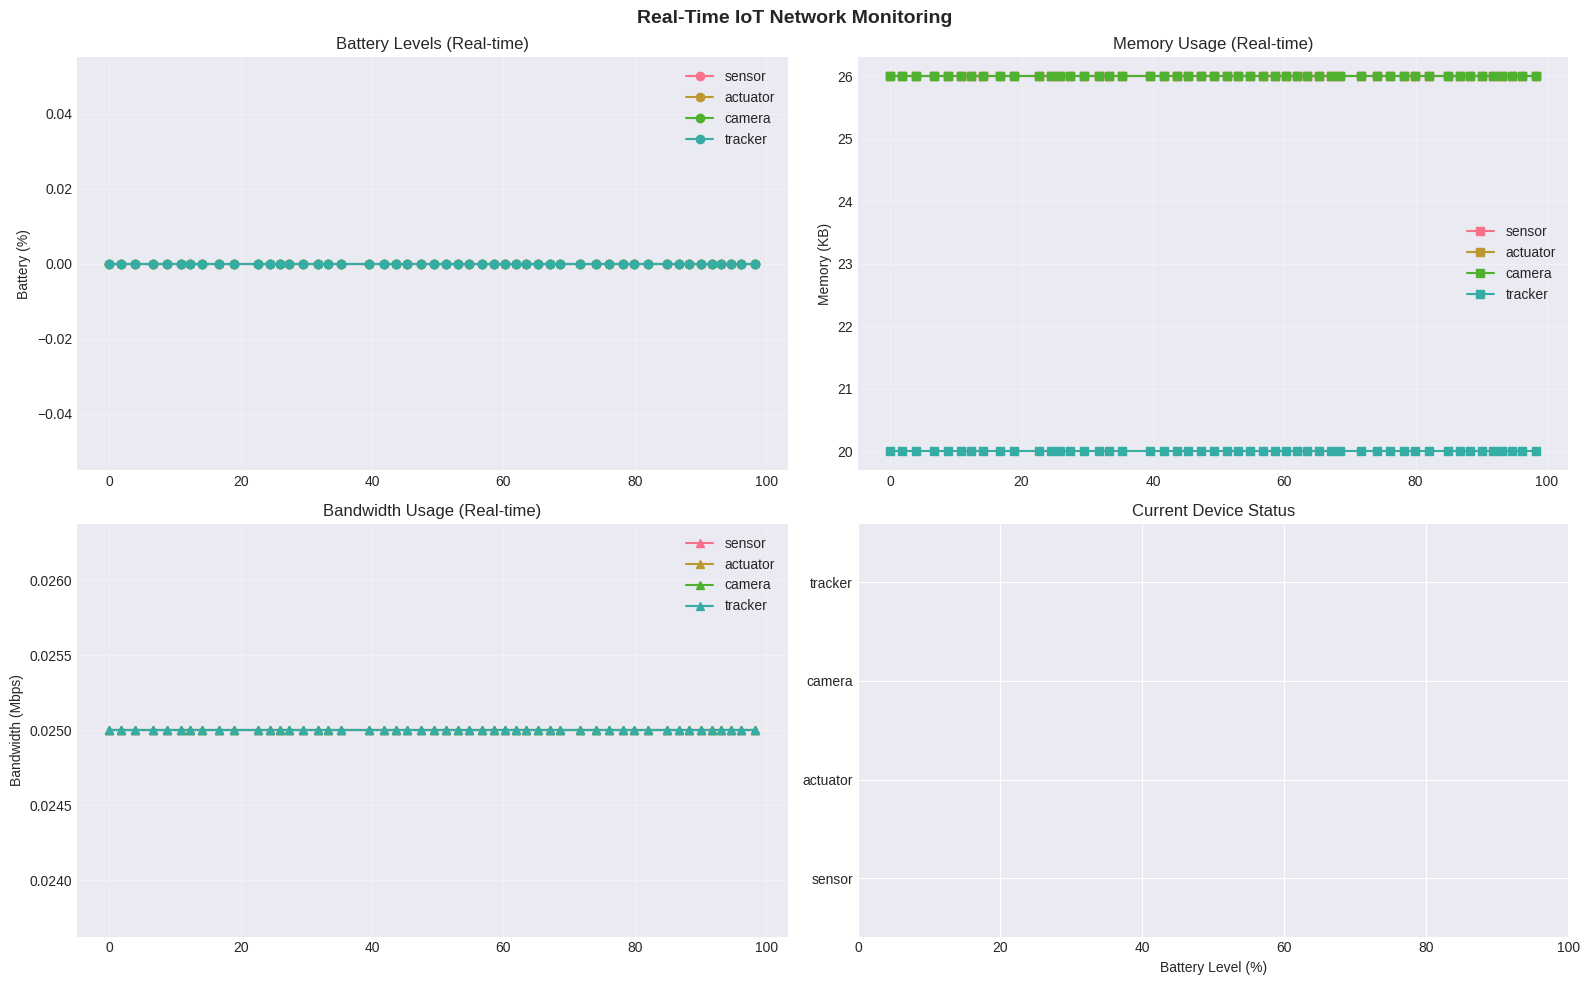

In [8]:
# Create simulation
def main():
    sim = NetworkSimulator()
    
    # Add IoT devices with different initial battery levels
    device_configs = [
        ("sensor", 95.0),
        ("actuator", 80.0),
        ("camera", 60.0),
        ("tracker", 40.0)
    ]
    
    for device_id, battery in device_configs:
        sim.add_device(device_id, battery)
    
    print("IoT Network Simulation Started")
    print("=" * 50)
    
    # Run simulation
    final_report = sim.run_simulation(duration=1000, step_delay=0.1)
    
    # Display final report
    print("\n" + "=" * 50)
    print("FINAL NETWORK REPORT")
    print("=" * 50)
    print(json.dumps(final_report, indent=2, default=str))
    
    # Create comprehensive dashboard with all visualizations
    print("\nGenerating comprehensive visual dashboard...")
    # sim.create_comprehensive_dashboard()
    
    # Optional: Create real-time animated dashboard
    # Uncomment the line below to see real-time animation
    print("\nCreating real-time dashboard (close window to continue)...")
    sim.create_real_time_dashboard(duration=60)

main()
